# Derivations for the Castro SDC Solver

This notebook contains the various derivations of the equations presented in the appendix of the Castro SDC paper.

In [1]:
from sympy import init_session
init_session()

IPython console for SymPy 1.3 (Python 3.7.4-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.3/



## Quadrature Formula

For the 4th order solver, use three points in time, $t^n$, $t^n + \delta t/2$, and $t^n + \delta t$ and we want to do an integral over these that is fourth order accurate.  

We'll define $\tau = \delta t/2$ as the interval between temporal, and then fit a parabola to the data at the three temporal nodes, $t_0$, $t_1 = t_0 + \tau$, $t_2 = t_1 + \tau$:

$$p(t) = a (t - t_0)^2 + b (t - t_0) + c$$

We then compute the integrals of this parabola in $[t_0, t_1]$ and $[t_1, t_2]$.

In [2]:
# define the symbols we need
A, B, C = symbols("A B C")
p0, p1, p2 = symbols("phi_0 phi_1 phi_2")
tau = symbols("tau")
t, t0 = symbols("t t_0")

Here is our polynomial:

In [3]:
p = A*(t - t0)**2 + B*(t - t0) + C

Now we solve for the coefficients, $A$, $B$, $C$, by requiring that:
\begin{align*}
p(t_0) &= \phi_0 \\
p(t_1) &= \phi_1 \\
p(t_2) &= \phi_2
\end{align*}

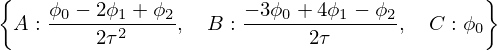

In [4]:
coeffs = solve([p.subs(t, t0)-p0, p.subs(t, t0+tau)-p1, p.subs(t, t0+2*tau)-p2], [A,B,C], check=False)
coeffs

Now we'll rewrite the polynomial using these values of $A$, $B$, $C$

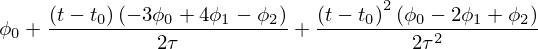

In [5]:
pp = coeffs[A]*(t - t0)**2 + coeffs[B]*(t - t0) + coeffs[C]
pp

### Construct the integrals

We integrate over each half of the time domain.  First we compute integral from $t_0$ to $t_1$

In [6]:
q = integrate(pp, (t, t0, t0+tau))

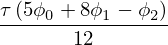

In [7]:
simplify(q)

Next we compute the integral from $t_1$ to $t_2$

In [8]:
q = integrate(pp, (t, t0+tau, t0+2*tau))

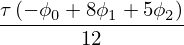

In [9]:
simplify(q)

## Appendix A: Jacobian

We want to compute the Jacobian $\partial w/\partial \mathcal{U}$ with

$\mathcal{U} = (\rho, \rho X_\alpha, \rho X_\beta, \rho e)^\intercal$

$w = (\rho, X_\alpha, X_\beta, T)^\intercal$

We'll start by writing down

$A = \partial \mathcal{U}/\partial w$

and then find its inverse

In [10]:
r, E, e, Xa, Xb = symbols(r"rho E e X_{\alpha} X_{\beta}")
dedr, dedT, dedXa, dedXb = symbols(r"\frac{\partial{}e}{\partial\rho} \frac{\partial{}e}{\partial{}T} " +
                                   r"\frac{\partial{}e}{\partial{}X_{\alpha}} \frac{\partial{}e}{\partial{}X_{\beta}}")

In [11]:
A = Matrix(
    [[1, 0, 0, 0],
     [Xa, r, 0, 0],
     [Xb, 0, r, 0],
     [e + r*dedr, r*dedXa, r*dedXb, r*dedT]])

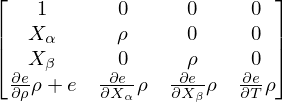

In [12]:
A

The inverse of $A$ is $\partial w/\partial \mathcal{U}$

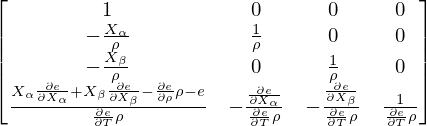

In [13]:
simplify(A.inv())

## Diffusion Differences

There are two forms of the derivative we need: a pointwise difference and one that acts on average.

### Pointwise difference

We can construct the derivative to 4th order by writing the following Taylor expansions:

\begin{align}
  T_{i+1} = T\left (x_{i+1/2} + \frac{h}{2}\right ) = T_{i+1/2} &+
    \left . \frac{dT}{dx}\right |_{i+1/2} \frac{h}{2} +
    \frac{1}{2} \left . \frac{d^2T}{dx^2}\right |_{i+1/2} \left (\frac{h}{2}\right )^2 \nonumber \\
    &+     \frac{1}{6} \left . \frac{d^3T}{dx^3}\right |_{i+1/2} \left (\frac{h}{2}\right )^3 +
    \frac{1}{24} \left . \frac{d^4T}{dx^4}\right |_{i+1/2} \left (\frac{h}{2}\right )^4 + \mathcal{O}(h^5) \\
  T_{i} = T\left (x_{i+1/2} - \frac{h}{2}\right ) = T_{i+1/2} &-
    \left . \frac{dT}{dx}\right |_{i+1/2} \frac{h}{2} + 
    \frac{1}{2} \left . \frac{d^2T}{dx^2}\right |_{i+1/2} \left (\frac{h}{2}\right )^2 \nonumber \\ 
    &-     \frac{1}{6} \left . \frac{d^3T}{dx^3}\right |_{i+1/2} \left (\frac{h}{2}\right )^3 +
    \frac{1}{24} \left . \frac{d^4T}{dx^4}\right |_{i+1/2} \left (\frac{h}{2}\right )^4 + \mathcal{O}(h^5)
\end{align}      
and similar for $T_{i-1}= T(x_{i+1/2} - 3h/2)$ and $T_i+2 = T(x_{i+1/2} + 3h/2)$

In [14]:
# define the symbols
Th = symbols("T_{i+1/2}")
dTdx, d2Tdx2, d3Tdx3, d4Tdx4 = symbols("dT/dx|_{i+1/2} " +
                                       "d^2T/dx^2|_{i+1/2} " +
                                       "d^3T/dx^3|_{i+1/2} " +
                                       "d^4T/dx^4|_{i+1/2}")
h = symbols("h")

Here are our 4 Taylor expansions

In [15]:
T1 = Th + dTdx * Rational(1,2)*h + Rational(1,2)*d2Tdx2 * Rational(1,2)**2 *h**2 + \
          Rational(1,6)*d3Tdx3 * Rational(1,2)**3 * h**3 + Rational(1,24)*d4Tdx4 * Rational(1,2)**4 *h**4
T0 = Th - dTdx * Rational(1,2)*h + Rational(1,2)*d2Tdx2 * Rational(1,2)**2 *h**2 - \
          Rational(1,6)*d3Tdx3 * Rational(1,2)**3 * h**3 + Rational(1,24)*d4Tdx4 * Rational(1,2)**4 *h**4
T2 = Th + dTdx * Rational(3,2)*h + Rational(1,2)*d2Tdx2 * Rational(3,2)**2 *h**2 + \
          Rational(1,6)*d3Tdx3 * Rational(3,2)**3 * h**3 + Rational(1,24)*d4Tdx4 * Rational(3,2)**4 *h**4
Tm1 = Th - dTdx * Rational(3,2)*h + Rational(1,2)*d2Tdx2 * Rational(3,2)**2 *h**2 - \
          Rational(1,6)*d3Tdx3 * Rational(3,2)**3 * h**3 + Rational(1,24)*d4Tdx4 * Rational(3,2)**4 *h**4

Notice the difference $T_{i+1} - T_i$:

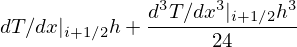

In [16]:
T1 - T0

and likewise the difference $T_{i+2} - T_{i-1}$

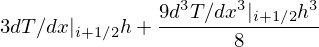

In [17]:
T2 - Tm1

This suggests that the combination:
$$\frac{-T_{i+2} + 27 T_{i+1} - 27 T_i + T_{i-1}}{24h} = \left . \frac{dT}{dx} \right |_{i+1/2}$$

In [18]:
(-T2 + 27*T1 - 27*T0 + Tm1)/(24*h)

Since we expanded to $h^4$ and no $h$ terms remain, this shows that this expression for the derivative is fourth order accurate.

### Cell-average difference

We want to construct a cubic polynomal through that goes through volumes $x_{i-1}$, $x_{i}$, $x_{i+1}$, $x_{i+2}$ and gives the correct averages,
$\langle f\rangle_{i-1}$, $\langle f\rangle_{i}$, $\langle f\rangle_{i+1}$, and $\langle f\rangle_{i+2}$ when integrated over the volume, e.g.

$$\frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} f(x) dx = \langle f\rangle_i$$

There are 4 unknowns in the quadratic and four constraints, so this is a linear system we can solve.

Define the quadratic polynomial, using $x_i$ as our reference

In [19]:
x0 = symbols("x_i")
a, b, c, d = symbols("a b c d")
f = a*(x-x0)**3 + b*(x-x0)**2 + c*(x-x0) + d
f

In [20]:
h = symbols("h")

### constraints

Define the 4 constraint equations---here we set them up construct $A$, $B$, $C$, and $D$ as the integrals over the 4 control volumes

Our linear system is now:

$$A = \langle f\rangle_{i-1}$$
$$B = \langle f\rangle_{i}$$
$$C = \langle f\rangle_{i+1}$$
$$D = \langle f\rangle_{i+2}$$

These are the function values we constrain to

In [21]:
fm, f0, fp, fp2 = symbols(r"{\langle{}f\rangle}_{i-1} {\langle{}f\rangle}_{i} {\langle{}f\rangle}_{i+1} {\langle{}f\rangle}_{i+2}")

Now define the interfaces

In [22]:
xm32 = x0 - Rational(3,2)*h
xm12 = x0 - Rational(1,2)*h
xp12 = x0 + Rational(1,2)*h
xp32 = x0 + Rational(3,2)*h
xp52 = x0 + Rational(5,2)*h

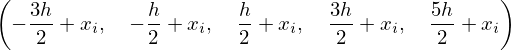

In [23]:
xm32, xm12, xp12, xp32, xp52

Next perform the integals of $f(x)$ over each zone

In [24]:
A = simplify(integrate(f/h, (x, xm32, xm12)))
B = simplify(integrate(f/h, (x, xm12, xp12)))
C = simplify(integrate(f/h, (x, xp12, xp32)))
D = simplify(integrate(f/h, (x, xp32, xp52)))

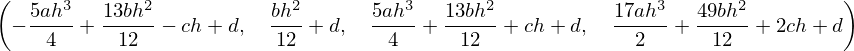

In [25]:
A, B, C, D

Finally find the coefficients of the polynomial

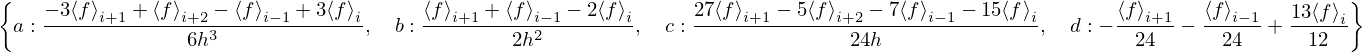

In [26]:
coeffs = solve([A-fm, B-f0, C-fp, D-fp2], [a,b,c,d], check=False)
coeffs

### interpolating polynomial

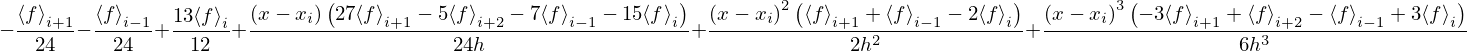

In [27]:
fc = f.subs(a,coeffs[a]).subs(b,coeffs[b]).subs(c,coeffs[c]).subs(d,coeffs[d])
fc

### derivative at i+1/2 interface

this interpolant is symmetric about the $i+1/2$ interface.  We'll compute the derivative there.

In [28]:
df = diff(fc, x).subs(x, xp12)

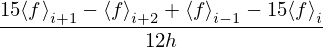

In [29]:
simplify(df)

### value at i+1/2 interface

Just as a check, the value of the polynomial itself, not the derivative, at the same interface should be the usual 7/12-1/12 rule we use for finding interface states.

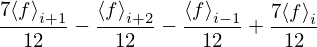

In [30]:
simplify(fc.subs(x, xp12))